# Classify Electrocardiograms

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=400>

### Exercise objectives:
- Discover a new type of application with temporal data
- Try different recurrent neural networks

We have seen that RNN are able to predict what happens after an observed sequence of data. Let's see here a different way of using RNN. Instead of predicting a value that occurs after the seen sequence, we will here classify the entire sequence itself, as if the whole sequence corresponds to a given category. 

## 1. Data

The data corresponds to electrocardiograms (ECG), which are basically heart beats. Each sequence is therefore a sequence of amplitudes. These ECG are often used to observe heart malfunctions! In this dataset, there are 87554 heart beats and each corresponds to a heart beat type, from 0 to 4:
- 0 : Normal beat
- 1 : Supraventricular
- 2 : Ventricular
- 3 : Fusion
- 4 : Beats that cannot be classified

### 1.2 Load Data
👇 Run the following command to download the data 

In [5]:
import pickle
with open('mypicklefile', 'wb') as f1:
    pickle.dump('ECG_data/X.npy', f1)

In [8]:
import pandas as pd

pd.read_pickle('ECG_data/X.npy')

UnpicklingError: STACK_GLOBAL requires str

In [2]:
import numpy as np

X = np.load('ECG_data/X.npy', allow_pickle=True)
y = np.load('ECG_data/y.npy', allow_pickle=True)

print(len(X), " time series") 
print(X)


87554  time series
[list([0.9779411554336546, 0.9264705777168274, 0.6813725233078002, 0.2450980395078659, 0.15441176295280454, 0.19117647409439087, 0.1519607901573181, 0.08578431606292723, 0.05882352963089942, 0.04901960864663124, 0.04411764815449715, 0.06127450987696649, 0.06617647409439087, 0.06127450987696649, 0.04901960864663124, 0.07352941483259201, 0.06127450987696649, 0.06127450987696649, 0.06617647409439087, 0.06862745434045793, 0.09558823704719543, 0.07598039507865906, 0.09313725680112839, 0.10539215803146361, 0.1151960790157318, 0.10294117778539656, 0.11764705926179887, 0.125, 0.1421568691730499, 0.12745098769664764, 0.1519607901573181, 0.14460784196853635, 0.16421568393707278, 0.14460784196853635, 0.15931372344493863, 0.1519607901573181, 0.15441176295280454, 0.1421568691730499, 0.1519607901573181, 0.1519607901573181, 0.14705882966518402, 0.13235294818878174, 0.12745098769664764, 0.1348039209842682, 0.13725490868091586, 0.11274509876966478, 0.10784313827753068, 0.105392158031

👇 We plot one ECG for each category in the dataset to see what an ECG looks like. Notice `np.argwhere` trick!

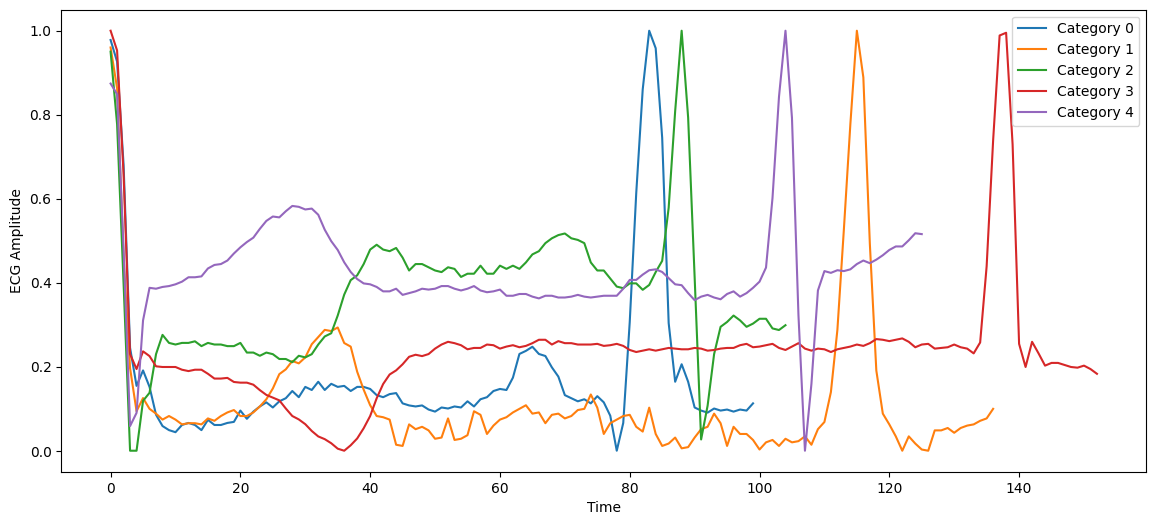

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i in range(5):
    idx_C = np.argwhere(np.array(y) == i)
    plt.plot(X[idx_C[0][0]], label=f'Category {i}')
    
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.show()

### 1.2 Padding

❓ **Question** ❓ You have probably noticed that each sequence (each ECG) has a different length. To corroborate your observation, plot the distribution of the sequence lengths in the dataset.

Text(0.5, 1.0, 'Distribution des longueurs des séries temporelles')

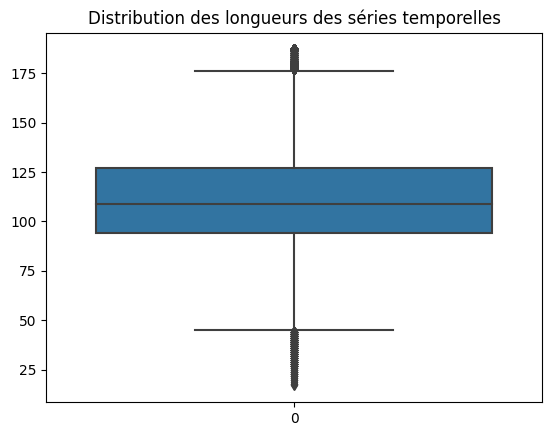

In [7]:
import seaborn as sns
lengths = [len(l) for l in X]
plot = sns.boxplot(lengths)
plot.set_title("Distribution des longueurs des séries temporelles")


You remember that we pass a batch of data to the neural network. Thus, the tensor will have the following shape 
>`(number of SEQUENCES, number of OBSERVATIONS per sequence, nbr of features per observation)`

- There are 87554 sequences
- Each observation is of size 1 (measured amplitude of ECG)

However, the number of observations per sequence vary from one sequence to another. For computational reasons, this cannot be feed into a RNN. For that reason, you need to **fill in the blanks** thanks to the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) so that each sequence is filled with fake values. The resulting sequences will all be of the same length.

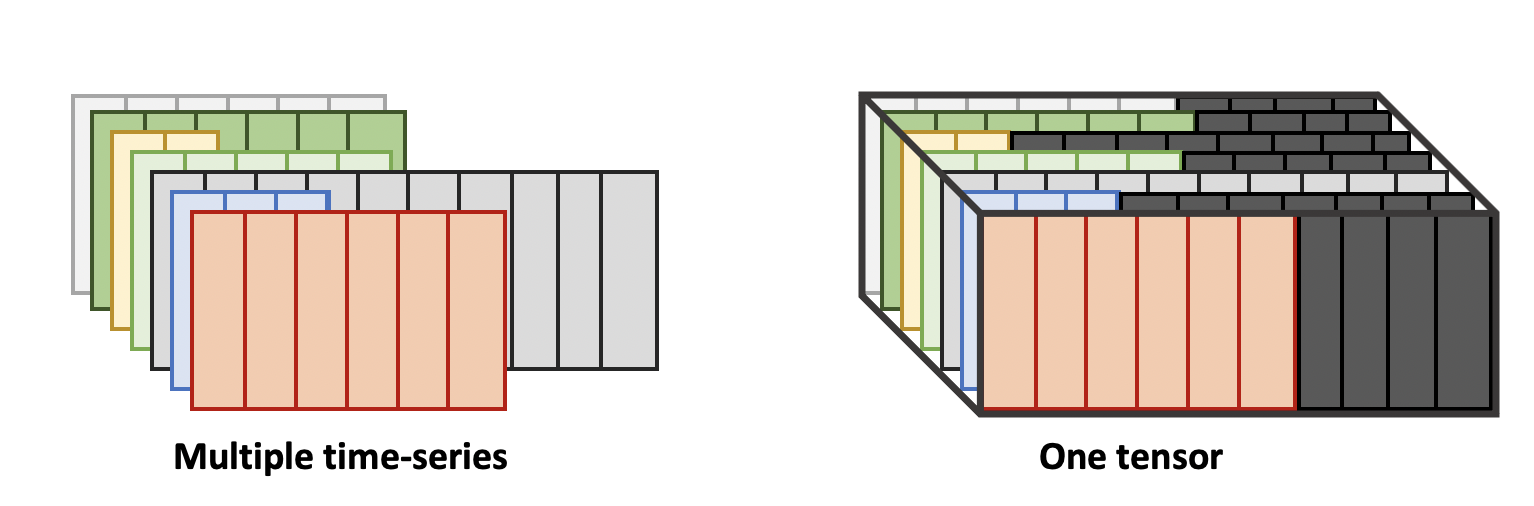



❓ **Question** ❓ Use the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function on X directly (without extra arguments here), store the result in `X_pad` and print the first sequence.

In [19]:
from keras.utils import pad_sequences, to_categorical
print(f"First sequence before padding: {X[0]}")

X_pad = pad_sequences(X)
print(f"First sequence after padding: {X_pad[0]}")

First sequence before padding: [0.9779411554336546, 0.9264705777168274, 0.6813725233078002, 0.2450980395078659, 0.15441176295280454, 0.19117647409439087, 0.1519607901573181, 0.08578431606292723, 0.05882352963089942, 0.04901960864663124, 0.04411764815449715, 0.06127450987696649, 0.06617647409439087, 0.06127450987696649, 0.04901960864663124, 0.07352941483259201, 0.06127450987696649, 0.06127450987696649, 0.06617647409439087, 0.06862745434045793, 0.09558823704719543, 0.07598039507865906, 0.09313725680112839, 0.10539215803146361, 0.1151960790157318, 0.10294117778539656, 0.11764705926179887, 0.125, 0.1421568691730499, 0.12745098769664764, 0.1519607901573181, 0.14460784196853635, 0.16421568393707278, 0.14460784196853635, 0.15931372344493863, 0.1519607901573181, 0.15441176295280454, 0.1421568691730499, 0.1519607901573181, 0.1519607901573181, 0.14705882966518402, 0.13235294818878174, 0.12745098769664764, 0.1348039209842682, 0.13725490868091586, 0.11274509876966478, 0.10784313827753068, 0.105392

❓ **Question** ❓ You probably see that the returned sequence is composed only of 0's. The reason is because, by default, `pad_sequences` returns integers. If a float is between 0.0 and 0.99999, it is converted to 0. To change this default behavior, turn the `dtype` argument of `pad_sequences` to `float32`. Pad once again the sequences, store the new result in `X_pad` and print the first sequence.

In [20]:
print(f"First sequence before padding: {X[0]}")

X_pad = pad_sequences(X,
                         dtype="float32")
print(f"First sequence after padding: {X_pad[0]}")

First sequence before padding: [0.9779411554336546, 0.9264705777168274, 0.6813725233078002, 0.2450980395078659, 0.15441176295280454, 0.19117647409439087, 0.1519607901573181, 0.08578431606292723, 0.05882352963089942, 0.04901960864663124, 0.04411764815449715, 0.06127450987696649, 0.06617647409439087, 0.06127450987696649, 0.04901960864663124, 0.07352941483259201, 0.06127450987696649, 0.06127450987696649, 0.06617647409439087, 0.06862745434045793, 0.09558823704719543, 0.07598039507865906, 0.09313725680112839, 0.10539215803146361, 0.1151960790157318, 0.10294117778539656, 0.11764705926179887, 0.125, 0.1421568691730499, 0.12745098769664764, 0.1519607901573181, 0.14460784196853635, 0.16421568393707278, 0.14460784196853635, 0.15931372344493863, 0.1519607901573181, 0.15441176295280454, 0.1421568691730499, 0.1519607901573181, 0.1519607901573181, 0.14705882966518402, 0.13235294818878174, 0.12745098769664764, 0.1348039209842682, 0.13725490868091586, 0.11274509876966478, 0.10784313827753068, 0.105392

The neural network, thanks to a `Masking` layer, will remove the 0 that you padded for computational reasons. 

**However**, if you look closely at the padded version of the first sequence, you have the padded zeros at the beginning of the sequence. But, also, there is a 0 value **_IN_** the heart-beat values. 
How could the neural network know which one to keep and which one to remove?

❓ **Question** ❓ Add the `value` keyword in the `pad_sequences` function to pad with values that **ARE NOT** in the initial dataset. Negative values for instance. Store it in `X_pad` and print the first sequence.

❗ **Remark** ❗ This is a good habit to pad the values **at the end** of the sequence (instead of the beginning as it is done by default). You can do that thanks to the `padding` keyword set to `post` (instead of `pre` by default).

[See full documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [21]:
print(f"First sequence before padding: {X[0]}")

X_pad = pad_sequences(X,
                         dtype="float32",
                         value=-1000,
                         padding="post")
print(f"First sequence after padding: {X_pad[0]}")

First sequence before padding: [0.9779411554336546, 0.9264705777168274, 0.6813725233078002, 0.2450980395078659, 0.15441176295280454, 0.19117647409439087, 0.1519607901573181, 0.08578431606292723, 0.05882352963089942, 0.04901960864663124, 0.04411764815449715, 0.06127450987696649, 0.06617647409439087, 0.06127450987696649, 0.04901960864663124, 0.07352941483259201, 0.06127450987696649, 0.06127450987696649, 0.06617647409439087, 0.06862745434045793, 0.09558823704719543, 0.07598039507865906, 0.09313725680112839, 0.10539215803146361, 0.1151960790157318, 0.10294117778539656, 0.11764705926179887, 0.125, 0.1421568691730499, 0.12745098769664764, 0.1519607901573181, 0.14460784196853635, 0.16421568393707278, 0.14460784196853635, 0.15931372344493863, 0.1519607901573181, 0.15441176295280454, 0.1421568691730499, 0.1519607901573181, 0.1519607901573181, 0.14705882966518402, 0.13235294818878174, 0.12745098769664764, 0.1348039209842682, 0.13725490868091586, 0.11274509876966478, 0.10784313827753068, 0.105392

### 1.3 Reshaping

In [13]:
assert X_pad.shape == (87554, 187)

☝️ We are missing one dimension, the last one (corresponding to the number of features per observations)

❓ **Question** ❓ To remedy this issue, expand the last dimension thanks to the `np.expand_dims` function. 

In [15]:
X_pad = np.expand_dims(X_pad, axis=-1)

In [16]:
assert(X_pad.shape == (87554, 187, 1))

❓ **Question** ❓ The labels `y` have to be one-hot encoded categories. For that reason, transform them to categories thanks to the appropriate Keras function and store the result in `y_cat`

In [22]:
y_cat = to_categorical(y, 5)
print(y_cat)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


❓ **Question** ❓ Split your data between a train and test set (80/20 ratio).

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# 2. Model

Each sequences comprises of lots of observations (187 units of time), and your intuition should tell you that ALL of them matters to diagnosis diseases (not just the "recent" ones). 

The LSTM or GRU model, with their ability to avoid vanishing gradient, should be preferred over RNN.

❓ **Question** ❓ Write model that has the following layers:
- a Masking layer whose `mask_value` corresponds to the value you decided to pad your data with (it is probably a negative value as suggested) - this layer will simply tell the network not to take into account the computation artifact
- Two stacked `GRU` layers with 20 units each, and the `tanh` as the activation function
- a dense layer with 50 units
- a dropout layer with 20% drop
- a last layer

and print model `summary()`

In [60]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Masking
from keras.callbacks import EarlyStopping


model = Sequential()

mask = Masking(mask_value=-1000,
               input_shape=(187, 1))
model.add(mask)

gru1 = GRU(units=20,
                activation="tanh",
                return_sequences=True)
model.add(gru1)

gru2 = GRU(units=20,
                activation="tanh",
                )
model.add(gru2)

dense_layer = Dense(50)
model.add(dense_layer)

drop = Dropout(rate=0.2)
model.add(drop)

output_layer = Dense(5, activation="softmax")
model.add(output_layer)

model.build(X_train.shape)
print(model.summary())


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_26 (Masking)        (None, 187, 1)            0         
                                                                 
 gru_39 (GRU)                (None, 187, 20)           1380      
                                                                 
 gru_40 (GRU)                (None, 20)                2520      
                                                                 
 dense_34 (Dense)            (None, 50)                1050      
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 5)                 255       
                                                                 
Total params: 5,205
Trainable params: 5,205
Non-train

❓ **Question** ❓ Compile and train your model. 

You will notice that it can take a very long time per epoch, even with GPUs. RNNs are, by nature, harder to distribute than CNNs. Indeed, GPUs work best when `trainable_params` is large (which is not the case here), or when `batch_size` is large 

- To reduce the duration of each epoch, use a larger batch size (e.g 128)

- Use also very small patience equal to 1 should be sufficient. This is because you have a lot of sequences and thus, many optimizations per epochs, even with relatively large batch_size




In [62]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

stop = EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

print(X_train.shape)
model.fit(x=X_train,
          y=y_train,
          epochs=100,
          batch_size=128,
          verbose=2,
          callbacks=[stop],
          validation_split=0.2)

(70043, 187)
Epoch 1/100
438/438 - 76s - loss: 0.6685 - accuracy: 0.8266 - val_loss: 0.6498 - val_accuracy: 0.8301 - 76s/epoch - 173ms/step
Epoch 2/100
438/438 - 69s - loss: 0.6663 - accuracy: 0.8266 - val_loss: 0.6472 - val_accuracy: 0.8301 - 69s/epoch - 158ms/step
Epoch 3/100
438/438 - 68s - loss: 0.6664 - accuracy: 0.8266 - val_loss: 0.6472 - val_accuracy: 0.8301 - 68s/epoch - 156ms/step
Epoch 4/100
438/438 - 69s - loss: 0.6665 - accuracy: 0.8266 - val_loss: 0.6469 - val_accuracy: 0.8301 - 69s/epoch - 157ms/step
Epoch 5/100
438/438 - 69s - loss: 0.6653 - accuracy: 0.8266 - val_loss: 0.6489 - val_accuracy: 0.8301 - 69s/epoch - 158ms/step


❓ **Question** ❓ Evaluate your model on the test data.

In [63]:
print(f"Accuracy on testing data: {model.evaluate(X_test, y_test)[1]}")

548/548 [==============================] - 16s 29ms/step - loss: 0.6528 - accuracy: 0.8294
Accuracy on testing data: 0.8294215202331543


❓ **Question** ❓ What is the accuracy of a baseline model which would predict, for `y_test`, the most probable category in y_train.

In [77]:
from sklearn.metrics import accuracy_score

counts = np.unique(y_train, axis=0, return_counts=True)
print(counts)
most_likely_cat = counts[0][4]
dummy_y = np.tile(most_likely_cat, (len(y_test), 1))

print(f"Baseline accuracy: {accuracy_score(y_test, dummy_y)}")

(array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32), array([ 5195,   507,  4593,  1801, 57947]))
Baseline accuracy: 0.8294215064816401


Basically, your RNNs are as good (bad?) as a model that predicts the most present category. The reason is probably because the RNNs really return only the most present category.

❓ **Question** ❓ Use the `predict` function to see what are the different categories the model is predicting. Compare the 5 predict probas of each sequence with the distribution of each 5 classes

In [87]:
class_distributions = np.sum(y_train, axis=0)/y_train.shape[0]
print(f"Distribution des classes : {class_distributions}")
print(f"Prédictions : {model.predict(X_test)}")


Distribution des classes : [0.82730608 0.02571278 0.065574   0.00723841 0.07416872]
548/548 [==============================] - 16s 29ms/step
Prédictions : [[0.8319292  0.02411454 0.06377743 0.00694263 0.07323622]
 [0.8322842  0.02409659 0.06339341 0.00689257 0.07333328]
 [0.833129   0.02401741 0.06257383 0.00678453 0.07349537]
 ...
 [0.8314458  0.02405759 0.0641102  0.00701274 0.07337375]
 [0.8276499  0.02459285 0.0670461  0.0074312  0.07327989]
 [0.828991   0.02439953 0.06607069 0.00728815 0.0732507 ]]


😱 Your model is returning exactly the frequence of each labels in your training set!

👉 A possibility here is to either subsample the data to have balanced classes in the training set. Another possibility is to do some data augmentation on temporal data. However, none of these methods would work right away. In fact, predicting the category of ECG data is not an easy task - also, you have only **one** heart-beat per patient, no repetitions of them! 

Classifying ECG is actually quite a complex task! Don't try to improve results, you won't be able to do so from this too small a dataset.

**The lesson here is not to be satisfied with results until you have compare them to a baseline method.**

🏁 Congratulation!